In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\Users\Vu Anh Vinh\Miniconda3\envs\thkstat\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

NameError: name 'file' is not defined

In [4]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

NameError: name 'file' is not defined

In [5]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(open("us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [6]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [7]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

OSError: File b'data/electoral_votes.csv' does not exist

In [8]:
electoral_votes = pd.read_csv("electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


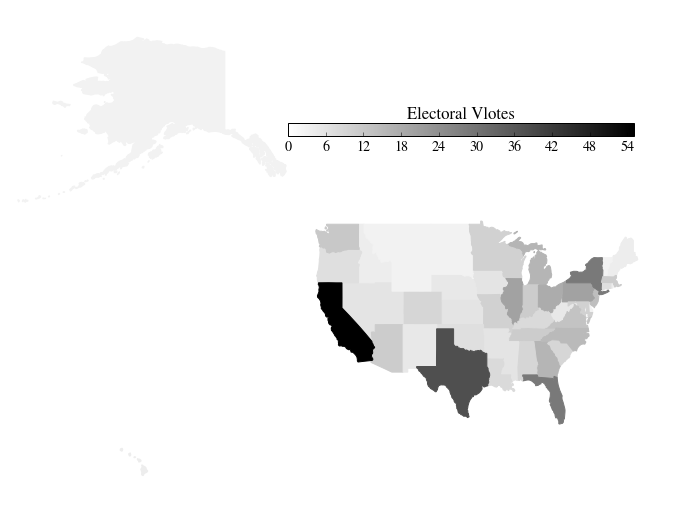

In [9]:
make_map(electoral_votes.Votes, "Electoral Vlotes");

In [10]:
predictwise = pd.read_csv('predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


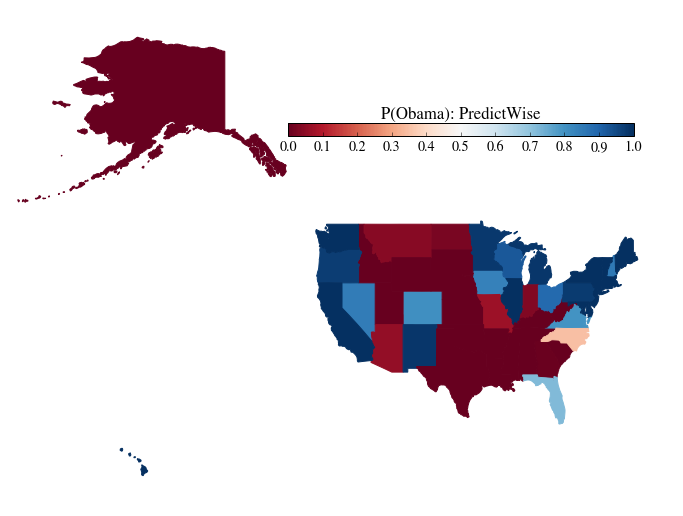

In [11]:
make_map(predictwise.Obama, "P(Obama): PredictWise")

In [12]:
np.random.uniform(size=(51, 5))

array([[  8.24196625e-01,   9.39097585e-01,   2.24033799e-01,
          8.00215768e-02,   1.88632313e-02],
       [  8.39560681e-01,   5.15759704e-03,   8.07528769e-01,
          5.69770717e-02,   8.30115987e-01],
       [  2.01256425e-01,   7.16349624e-01,   3.57922193e-01,
          8.28260823e-01,   4.09542962e-02],
       [  9.90805498e-01,   8.48352913e-01,   1.11372577e-01,
          6.39405115e-01,   2.44850524e-01],
       [  2.42557750e-02,   1.16126290e-01,   9.97957378e-01,
          3.60073171e-01,   4.46341142e-01],
       [  7.35635079e-01,   5.68854234e-01,   4.47937273e-01,
          1.54320659e-01,   9.19169340e-02],
       [  7.89131433e-01,   8.58959420e-01,   1.67841785e-01,
          4.40745366e-01,   7.90004056e-01],
       [  7.15335351e-01,   9.12608981e-01,   2.67437889e-02,
          3.06677196e-01,   2.61037253e-01],
       [  4.07642676e-01,   6.25589167e-01,   7.23343218e-01,
          9.64636254e-01,   1.66397708e-01],
       [  1.81206121e-01,   5.1899033

In [13]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""

#Your code here
def simulate_election(model, n_sim):
    #each column simulates a single outcome from the 50 states + DC
    #Obama wins the simulation if the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

In [14]:
result = simulate_election(predictwise, 10000)

In [15]:
#compute the probability of an Obama win, given this simulation
print (result >= 269).mean()

[ True  True  True ...,  True  True  True]


AttributeError: 'NoneType' object has no attribute 'mean'

In [16]:
#compute the probability of an Obama win, given this simulation
print((result >= 269).mean())

0.9957


In [17]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes Obama wins in each simulation.
    
Returns
-------
Nothing 
"""

#your code here

def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()

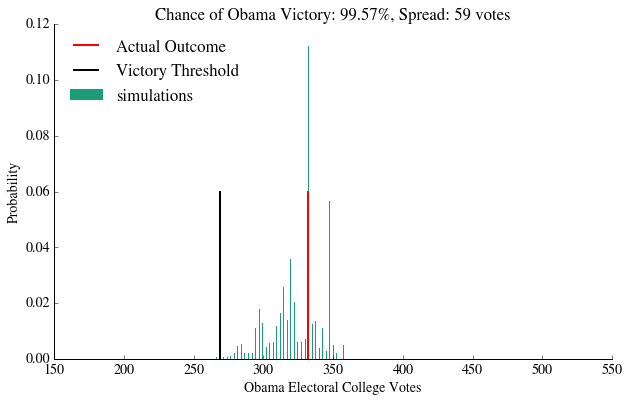

In [18]:
plot_simulation(result)

In [19]:
gallup_2012=pd.read_csv("g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


In [20]:
"""
Function
--------
simple_gallup_model

A simple forecast that predicts an Obama (Democratic) victory with
0 or 100% probability, depending on whether a state
leans Republican or Democrat.

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama. All values should be 0 or 1
    model.index should be set to gallup.index (that is, it should be indexed by state name)
    
Examples
---------
>>> simple_gallup_model(gallup_2012).ix['Florida']
Obama    1
Name: Florida, dtype: float64
>>> simple_gallup_model(gallup_2012).ix['Arizona']
Obama    0
Name: Arizona, dtype: float64
"""

def simple_gallup_model(gallup):
    return pd.DataFrame(dict(Obama=(gallup.Dem_Adv > 0).astype(float)))

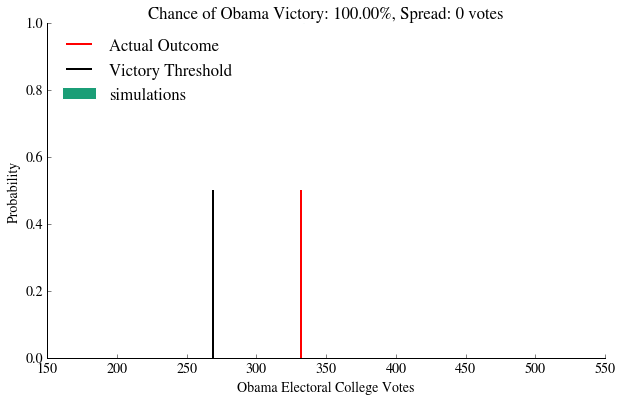

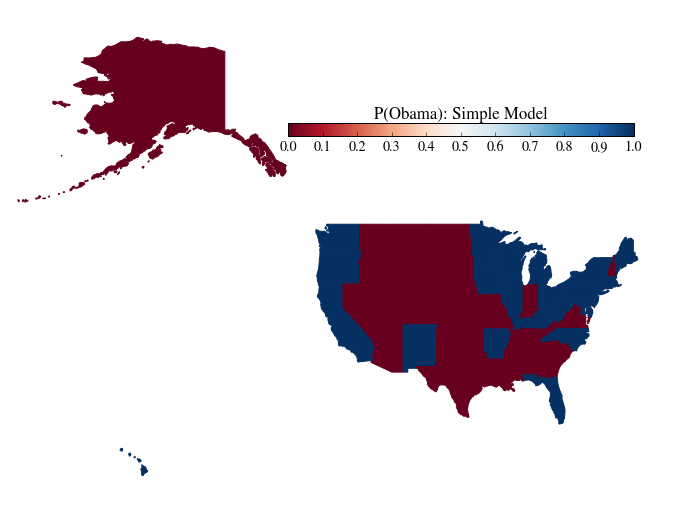

In [21]:
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

In [22]:
national_results=pd.read_csv("nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


In [23]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

OSError: File b'data/p04.csv' does not exist

In [24]:
polls04=pd.read_csv("p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [25]:
gallup_08 = pd.read_csv("g08.csv").set_index('State')
results_08 = pd.read_csv('2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

C:\Users\Vu Anh Vinh\Miniconda3\envs\thkstat\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


In [26]:
e2008=pd.DataFrame(dict(pvi=pvi08, Dem_Win = prediction_08.Dem_Win, Dem_Adv=prediction_08.Dem_Adv-prediction_08.Dem_Adv.mean()))
e2008['obama_win']=1*(prediction_08.Dem_Win > 0)
e2008 = e2008.sort_index()
e2008.head()

NameError: name 'pvi08' is not defined

In [27]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
e2008=pd.DataFrame(dict(pvi=pvi08, Dem_Win = prediction_08.Dem_Win, Dem_Adv=prediction_08.Dem_Adv-prediction_08.Dem_Adv.mean()))
e2008['obama_win']=1*(prediction_08.Dem_Win > 0)
e2008 = e2008.sort_index()
e2008.head()

,Dem_Adv,Dem_Win,pvi,obama_win
State,,,,
Alabama,-13.154902,-21.58,-23,0
Alaska,-22.954902,-21.53,-25,0
Arizona,-12.754902,-8.52,-8,0
Arkansas,0.145098,-19.86,-6,0
California,7.045098,24.06,12,1


In [28]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


In [29]:
results2012 = pd.read_csv("2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


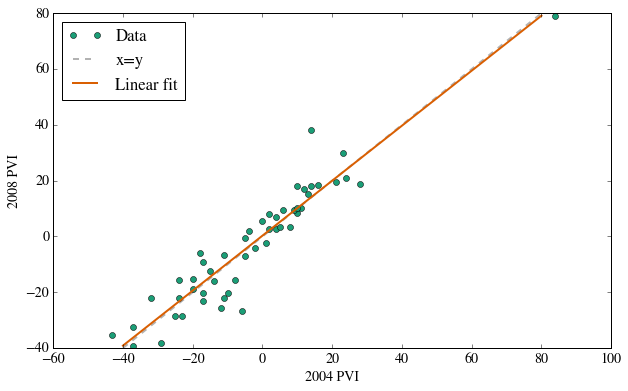

In [30]:
# There is a reasonably well fit line which hugs the x=y line. 
# This tells us that the PVI seems relatively stable from election to election and may thus make a good predictor
plt.plot(e2008.pvi, e2012.pvi, 'o', label='Data')
fit = np.polyfit(e2008.pvi, e2012.pvi, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, x, '--k', alpha=.3, label='x=y')
plt.plot(x, y, label='Linear fit')
plt.xlabel("2004 PVI")
plt.ylabel("2008 PVI")
plt.legend(loc='upper left')

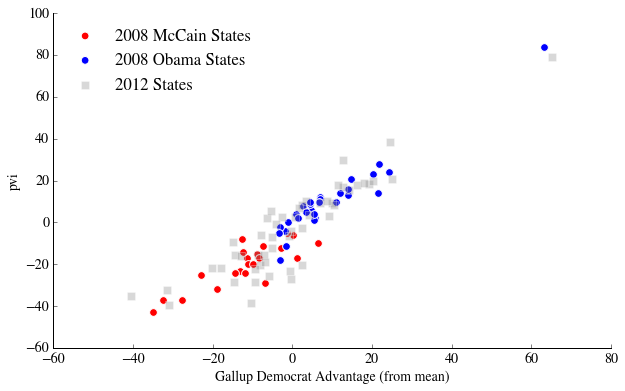

In [31]:
plt.xlabel("Gallup Democrat Advantage (from mean)")
plt.ylabel("pvi")
colors=["red","blue"]
ax=plt.gca()
for label in [0, 1]:
    color = colors[label]
    mask = e2008.obama_win == label
    l = '2008 McCain States' if label == 0 else '2008 Obama States'
    ax.scatter(e2008[mask]['Dem_Adv'], e2008[mask]['pvi'], c=color, s=60, label=l)

ax.scatter(e2012['Dem_Adv'], e2012['pvi'], c='gray', s=60, 
           marker="s", label='2012 States', alpha=.3)
plt.legend(frameon=False, scatterpoints=1, loc='upper left')
remove_border()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

# estimate C, regularized parameter
def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

# final function to make fit to Logistic Regression
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

In [33]:
res, clf = cv_and_fit(e2008, e2012, ['Dem_Adv', 'pvi'])
predict2012_logistic = res.join(electoral_votes)
predict2012_logistic.head()

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55


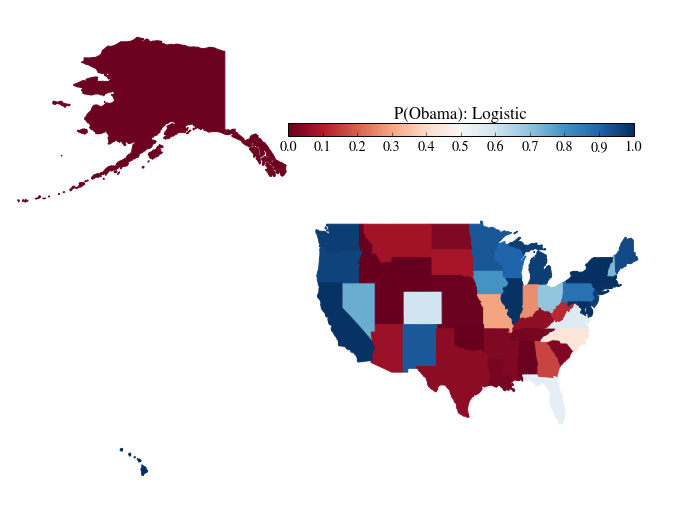

In [34]:
#code to make the map
make_map(predict2012_logistic.Obama, "P(Obama): Logistic")

In [35]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax

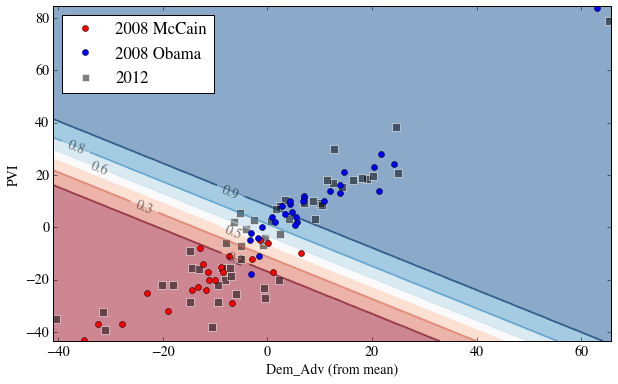

In [36]:
# classifier decision boundary
points_plot(e2008, e2012, clf)
plt.xlabel("Dem_Adv (from mean)")
plt.ylabel("PVI")